In [30]:
import pandas as pd

# read all the er files
pre = pd.read_csv("error_rates_precovid.csv")
post = pd.read_csv("error_rates_postcovid.csv")
y2013 = pd.read_excel("2013-rates.xlsx")
y2014 = pd.read_excel("2014-rates.xlsx")
y2012 = pd.read_excel("2012-rates.xlsx")
y2011 = pd.read_excel("2011-rates.xlsx")
y2010 = pd.read_excel("2010-rates.xlsx")
y2009 = pd.read_excel("2009-rates.xlsx")
y2008 = pd.read_excel("2008-rates.xlsx")

# check the columns
print(pre.columns)
print(post.columns)
print(y2013.columns)
print(y2014.columns)


Index(['year', 'state', 'over_payment', 'under_payment', 'error_rates'], dtype='object')
Index(['year', 'state', 'over_payment', 'under_payment', 'error_rates'], dtype='object')
Index(['State', 'Over\nPayments', 'Under\n     Payments', 'Error Rates', '1/'], dtype='object')
Index(['State', 'Over\nPayments', 'Under\n    Payments', 'Error Rates'], dtype='object')


In [32]:
def clean_df(df, year_col=None, year_value=None):
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    state_col = [c for c in df.columns if 'state' in c][0]
    error_col = [c for c in df.columns if 'error' in c][0]
    df = df.rename(columns={state_col: 'state', error_col: 'error_rate'})
    if year_col:
        df = df.rename(columns={year_col: 'year'})
    elif year_value:
        df['year'] = year_value
    return df[['state', 'year', 'error_rate']]

# standardize all the files
pre_clean = clean_df(pre)
post_clean = clean_df(post)
y2014_clean = clean_df(y2014, year_value=2014)
y2013_clean = clean_df(y2013, year_value=2013)
y2012_clean = clean_df(y2012, year_value=2012)
y2011_clean = clean_df(y2011, year_value=2011)
y2010_clean = clean_df(y2010, year_value=2010)
y2009_clean = clean_df(y2009, year_value=2009)
y2008_clean = clean_df(y2008, year_value=2008)

# concat all the files
df_all = pd.concat([y2008_clean, y2009_clean, y2010_clean, y2011_clean, y2012_clean, y2013_clean, y2014_clean, pre_clean, post_clean], ignore_index=True)

# basic clean
df_all['state'] = df_all['state'].str.strip().str.upper()
df_all['error_rate'] = pd.to_numeric(df_all['error_rate'], errors='coerce')
df_all = df_all.dropna(subset=['state', 'year', 'error_rate']).reset_index(drop=True)
df_all['state'] = df_all['state'].replace({
    'DIST. OF COL.': 'DISTRICT OF COLUMBIA'
})

# check the results
print(df_all.head())
print(df_all.shape)


        state  year  error_rate
0     ALABAMA  2008        4.23
1      ALASKA  2008        7.48
2     ARIZONA  2008        4.68
3    ARKANSAS  2008        6.10
4  CALIFORNIA  2008        5.77
(689, 3)


In [34]:
import pandas as pd
import numpy as np

# read the policy files
policy = pd.read_excel("Self-employment Deduction.xlsx")

# check the columns
print(policy.columns)

# unify the states' names
policy.columns = [c.strip().lower() for c in policy.columns]
policy = policy.rename(columns={
    'state': 'state',
    'self-employment deduction': 'deduction',
    'implementation year': 'implementation_year'
})

# clean the states' name and year
policy['state'] = policy['state'].str.strip().str.upper()
policy['implementation_year'] = pd.to_numeric(policy['implementation_year'], errors='coerce')

# define whether SED is implemented
policy['sed_adopted'] = np.where(policy['implementation_year'].notna(), 1, 0)

print(policy.head())


Index(['State', 'Self-employment Deduction', 'Implementation Year', 'Notes'], dtype='object')
        state deduction  implementation_year  notes  sed_adopted
0     ALABAMA       0.4               2009.0    NaN            1
1      ALASKA       0.5               2011.0    NaN            1
2     ARIZONA       0.4               2016.0    NaN            1
3    ARKANSAS    Actual                  NaN    NaN            0
4  CALIFORNIA       0.4               2009.0    NaN            1


In [42]:
df_all['state'] = df_all['state'].str.strip().str.upper()

# concat
df = df_all.merge(policy[['state', 'implementation_year', 'sed_adopted']], on='state', how='left')

print(df.head())


        state  year  error_rate  implementation_year  sed_adopted
0     ALABAMA  2008        4.23               2009.0          1.0
1      ALASKA  2008        7.48               2011.0          1.0
2     ARIZONA  2008        4.68               2016.0          1.0
3    ARKANSAS  2008        6.10                  NaN          0.0
4  CALIFORNIA  2008        5.77               2009.0          1.0


In [44]:
df['event_time'] = df['year'] - df['implementation_year']

# treated: whether sed been implemented
df['treated'] = (df['implementation_year'].notna()).astype(int)


In [50]:
import statsmodels.api as sm

# create event time virtual variables
K_MIN, K_MAX = -3, 5
for k in range(K_MIN, K_MAX + 1):
    if k == -1:  
        continue
    df[f'evt_{k}'] = ((df['treated'] == 1) & (df['event_time'] == k)).astype(int)

# add fixed effects
state_dummies = pd.get_dummies(df['state'], prefix='s', drop_first=True)
year_dummies = pd.get_dummies(df['year'], prefix='y', drop_first=True)

# regression
X = pd.concat([df[[f'evt_{k}' for k in range(K_MIN, K_MAX + 1) if k != -1]], state_dummies, year_dummies], axis=1)
X = sm.add_constant(X)
y = df['error_rate']

X = X.apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(y, errors="coerce")

# drop the na
mask = (~X.isna().any(axis=1)) & (~y.isna())
X = X.loc[mask]
y = y.loc[mask]

# transfer to  float
X = X.astype(float)
y = y.astype(float)


model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': df['state']})
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             error_rate   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     16.09
Date:                Tue, 21 Oct 2025   Prob (F-statistic):           1.04e-15
Time:                        18:41:08   Log-Likelihood:                -1855.2
No. Observations:                 689   AIC:                             3856.
Df Residuals:                     616   BIC:                             4187.
Df Model:                          72                                         
Covariance Type:              cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3

D:\soft\Anaconda\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 72, but rank is 20
  warnings.warn('covariance of constraints does not have full '


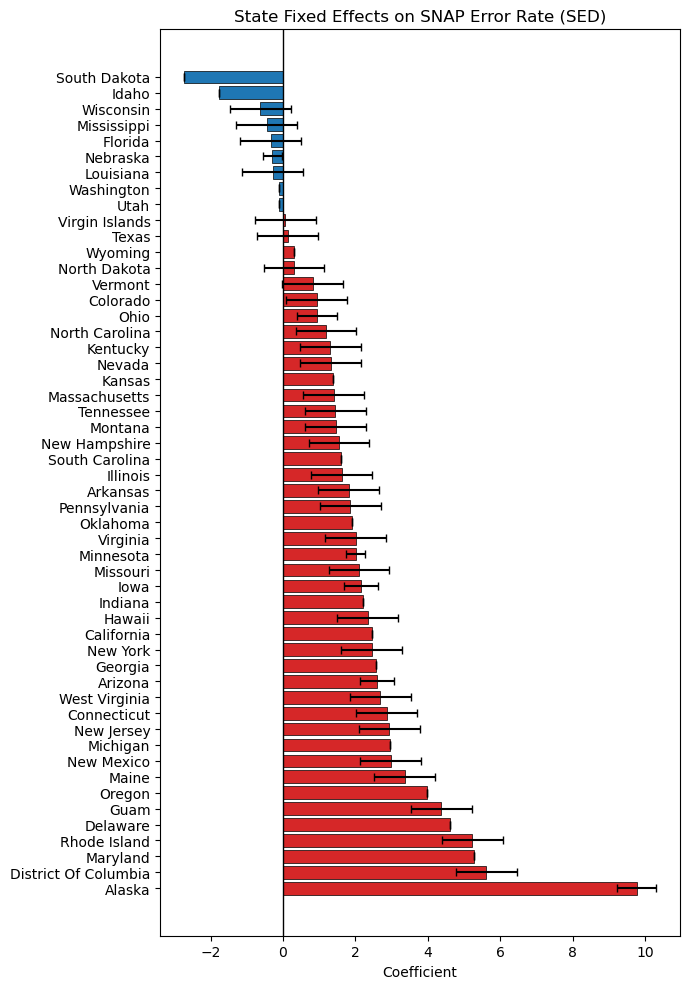

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import to_rgba

# 1. Extract state fixed effects (variables starting with "s_")
results_df = pd.DataFrame({
    "param": model.params.index,
    "coef": model.params.values,
    "se": model.bse.values
})

# confidential distribution
results_df["ci_lo"] = results_df["coef"] - 1.96 * results_df["se"]
results_df["ci_hi"] = results_df["coef"] + 1.96 * results_df["se"]

# 2. 过滤州固定效应
state_df = results_df[results_df["param"].str.startswith("s_")].copy()

# clean the states' name
state_df["state"] = state_df["param"].str.replace(r"^s_", "", regex=True).str.replace("_", " ").str.title()

# order by index
state_df = state_df.sort_values("coef", ascending=False).reset_index(drop=True)

# 3. set the color: red for positive, blue for negative
state_df["color"] = state_df["coef"].apply(lambda x: "#d62728" if x >= 0 else "#1f77b4")

# 4. draw the graph
plt.figure(figsize=(7, 10))

plt.barh(
    y=state_df["state"],
    width=state_df["coef"],
    color=state_df["color"],
    xerr=[state_df["coef"] - state_df["ci_lo"], state_df["ci_hi"] - state_df["coef"]],
    capsize=3,
    edgecolor="black",
    linewidth=0.5
)

# improve
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Coefficient")
plt.ylabel("")
plt.title("State Fixed Effects on SNAP Error Rate (SED)")

plt.tight_layout()
plt.show()


In [54]:
import pandas as pd

# --- Extract event-study coefficients from the model ---
rows = []

for name in model.params.index:
    if name.startswith("evt_"):  # only event-time dummies
        k = int(name.split("_")[1])      # extract the number after evt_
        beta = model.params[name]        # coefficient
        se = model.bse[name]             # standard error
        rows.append({
            "k": k,
            "beta": beta,
            "lo": beta - 1.96 * se,      # lower 95% CI
            "hi": beta + 1.96 * se       # upper 95% CI
        })

# Convert to DataFrame and sort by event time
es_df = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)

print(es_df)


   k      beta        lo        hi
0 -3 -0.274159 -2.870031  2.321712
1 -2 -2.368115 -6.975253  2.239024
2  0 -0.737187 -3.019266  1.544891
3  1 -0.311155 -2.268719  1.646409
4  2 -0.373549 -2.459330  1.712232
5  3 -0.755731 -3.117917  1.606455
6  4 -0.586626 -2.418179  1.244928
7  5 -0.990817 -2.877562  0.895928


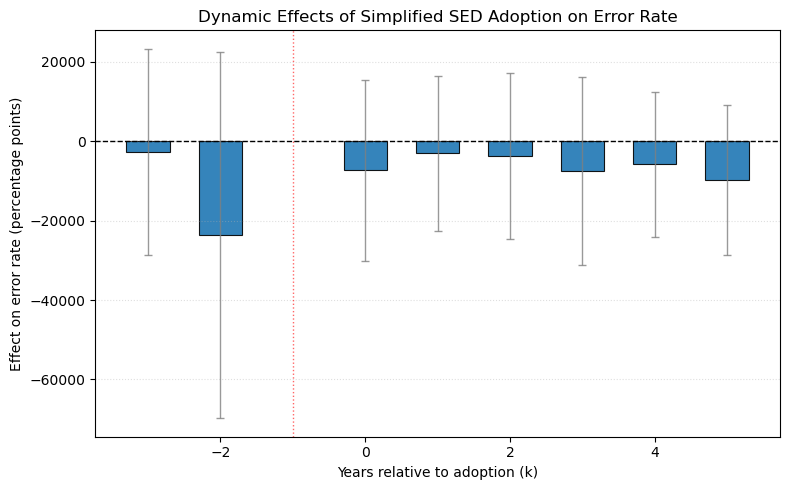

In [56]:
# containing columns: ['k', 'beta', 'lo', 'hi']
# If your effects are in proportions, convert them to percentage points
SCALE = 10000  # e.g., convert 0.05 (5%) to 500 percentage points

plt.figure(figsize=(8, 5))

# Baseline reference lines
plt.axhline(0, color="black", linestyle="--", linewidth=1)      # zero effect line
plt.axvline(-1, color="red", linestyle=":", linewidth=1, alpha=0.6)  # baseline period

# Bar chart with error bars
plt.bar(
    es_df["k"],                                   # x-axis: event time
    es_df["beta"] * SCALE,                        # y-axis: effect estimates
    color=["#1f77b4" if b < 0 else "#d62728" for b in es_df["beta"]],  # blue/red color by sign
    edgecolor="black",
    linewidth=0.8,
    alpha=0.9,
    width=0.6,
    yerr=[
        (es_df["beta"] - es_df["lo"]) * SCALE,    # lower error
        (es_df["hi"] - es_df["beta"]) * SCALE     # upper error
    ],
    capsize=3,                                    # error bar cap size
    error_kw=dict(elinewidth=1, ecolor="gray", alpha=0.8)  # error bar style
)

# Axis labels and title
plt.xlabel("Years relative to adoption (k)")
plt.ylabel("Effect on error rate (percentage points)")
plt.title("Dynamic Effects of Simplified SED Adoption on Error Rate")

# Layout and style tweaks
plt.grid(axis="y", linestyle=":", alpha=0.4)
plt.tight_layout()
plt.show()
